In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

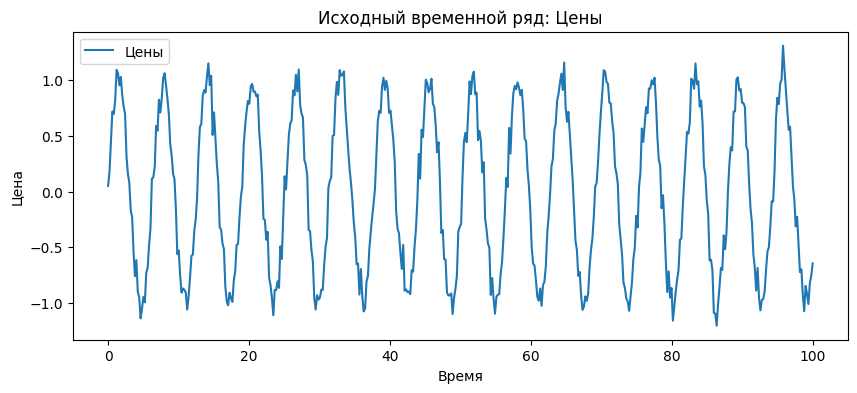

In [3]:
# 1. Генерация синтетического временного ряда цен
np.random.seed(42)
time_steps = 500
x = np.linspace(0, 100, time_steps)
prices = np.sin(x) + np.random.normal(scale=0.1, size=time_steps)  # Синусоидальный тренд с шумом

# Визуализация исходных данных
plt.figure(figsize=(10, 4))
plt.plot(x, prices, label="Цены")
plt.title("Исходный временной ряд: Цены")
plt.xlabel("Время")
plt.ylabel("Цена")
plt.legend()
plt.show()

# 2. Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

# 3. Создание последовательностей для обучения
def create_dataset(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x_seq = data[i:i + seq_length]
        y_next = data[i + seq_length]
        xs.append(x_seq)
        ys.append(y_next)
    return np.array(xs), np.array(ys)

seq_length = 10  # Длина последовательности
X, y = create_dataset(prices_scaled, seq_length)

# 4. Разделение на обучающую и тестовую выборки
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 5. Изменение формы данных для GRU: [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Epoch 1/100


c:\Users\chapa\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2745 - val_loss: 0.0492
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0431 - val_loss: 0.0437
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0359 - val_loss: 0.0298
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0301 - val_loss: 0.0257
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0238 - val_loss: 0.0214
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0203 - val_loss: 0.0180
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0170 - val_loss: 0.0148
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0139 - val_loss: 0.0114
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0109 - val_loss: 0.0082
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0073 - val_loss: 0.0052
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - val_loss: 0.0032
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

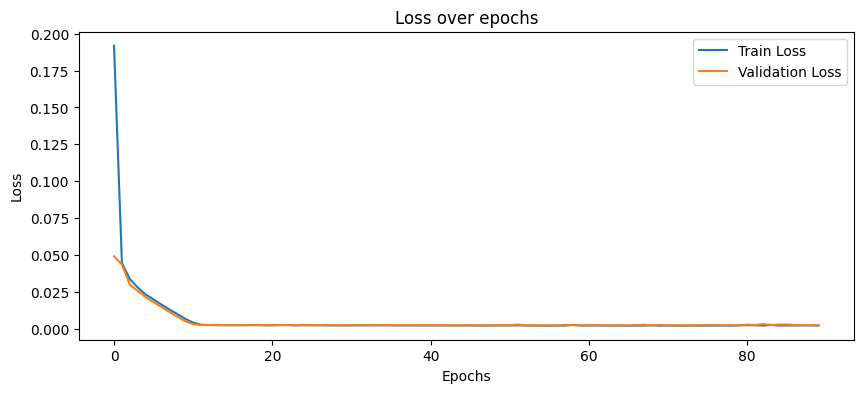

In [ ]:
# 6. Создание модели GRU
model = Sequential([
    GRU(50, activation='tanh', input_shape=(seq_length, 1)),  # Слой GRU с 50 нейронами
    Dense(1)  # Полносвязный слой для получения выходного значения
])

# 7. Компиляция модели
model.compile(optimizer='adam', loss='mse')

# 8. Настройка Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 9. Обучение модели
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# 10. Оценка модели
loss = model.evaluate(X_test, y_test)
print(f"Loss on test set: {loss}")

# 11. Визуализация потерь во время обучения
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


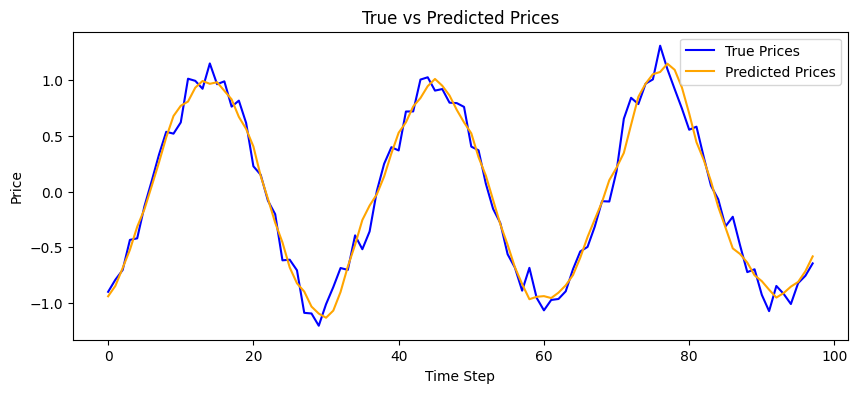

In [5]:
# 12. Прогнозирование
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)  # Обратное преобразование к исходному масштабу
y_test_rescaled = scaler.inverse_transform(y_test)

# 13. Визуализация прогнозов
plt.figure(figsize=(10, 4))
plt.plot(y_test_rescaled, label="True Prices", color='blue')
plt.plot(predictions_rescaled, label="Predicted Prices", color='orange')
plt.title("True vs Predicted Prices")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.show()

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 14. Расчет метрик
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
r2 = r2_score(y_test_rescaled, predictions_rescaled)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

MSE: 0.014430152801893147
RMSE: 0.12012557097426488
MAE: 0.09629517561261362
R-squared: 0.9723413743597639
